# HyperbolicTSNE

This notebook illustrates the usage of the HyperbolicTSNE library. Specifically, we load a subset of the MNIST dataset and embed it in hyperbolic space using the accelerated version of hyperbolic tsne. Finally, we save the embedding result as an image.

## Setup

First, we import the packages we will use and set important paths. Note that `hyperbolicTSNE.util` and `hyperbolicTSNE.visualization` contain useful functions for reading, processing and exporting embeddings. This requires that hyperbolicTSNE has been set up as detailed in the main readme of the repository. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import traceback
import importlib 

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import CoSNE, HyperbolicKL

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


We assume that there is a top-level folder `datasets` that holds the MNIST data set. Refer to the main readme of the repository for where to find the data sets used in this repository.

In [3]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots

## Configure

HyperbolicTSNE follows a similar API to other t-SNE libraries like OpenTSNE and sklearn. The configuration process consists of loading the data to embed and defining the settings of the embedder. We create a dict with parameters manually to demonstrate all the customization options. Nevertheless, `hyperbolicTSNE.hyperbolicTSNE` provides parameter templates to start with.

In [4]:
only_animate = False
seed = 42
dataset = Datasets.MNIST  # the Datasets handler provides access to several data sets used throughout the repository
num_points = 0.025  # we use a subset for demonstration purposes, full MNIST has N=70000
perp = 25  # we use a perplexity of 30 in this example
correct_grad = False
scale_fix = False
exact = False

dataX, dataLabels, D, V, _ = load_data(
    dataset, 
    data_home=data_home, 
    random_state=seed, 
    to_return="X_labels_D_V",
    hd_params={"perplexity": perp}, 
    sample=num_points, 
    knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
)

In [5]:
exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
main_iterations = 750 # ... followed by 750 iterations of non-exaggerated gradient descent.

opt_config = dict(
    cf=HyperbolicKL, # Cost function to use
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=exact,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=2000,  # Needed for early stopping criterion
    size_tol=0.999,  # Size of the embedding to be used as early stopping criterion
    grad_scale_fix=scale_fix,
    grad_fix=correct_grad
)

# Configure Optimizer with configuration options
opt_params = SequentialOptimizer.sequence_poincare(**opt_config)
opt_params["cf_params"].update({"grad_fix" : correct_grad})     # So the cost function knows which gradient to use

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

print(f"config: {opt_config}")

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.14583333333333334, 'learning_rate_main': 0.14583333333333334, 'exaggeration': 12, 'exaggeration_its': 250, 'gradientDescent_its': 750, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': False, 'area_split': False, 'n_iter_check': 2000, 'size_tol': 0.999, 'grad_scale_fix': False, 'grad_fix': False}


## Run HyperbolicTSNE

Embedding the high dimensional data consists of three steps:
- Initializating the embedding
- Initializing the embedder 
- Embedding the data

The following three cells demonstrate this process. Note that use set metric to "precomputed" because we pass the distance matrix to the `fit` method.

In [6]:
# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)

In [7]:
# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer,         # the optimizater we use
    opt_params=opt_params                   # the parameters for the optimizers
)

In [8]:
# Compute the embedding
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
    
except ValueError:
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 78.70922 grad_norm: 1.67061e+00: 100%|██████████| 250/250 [00:04<00:00, 59.51it/s]


[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.93924 grad_norm: 1.83201e-01: 100%|██████████| 750/750 [00:10<00:00, 70.66it/s]


## Exporting and visualization

After running the embedding process, the embeddings arrays are saved to the `log_path`. We can use this information to visualize the embeddings using utility functions defined in `hyperbolicTSNE.visualization` as shown below.

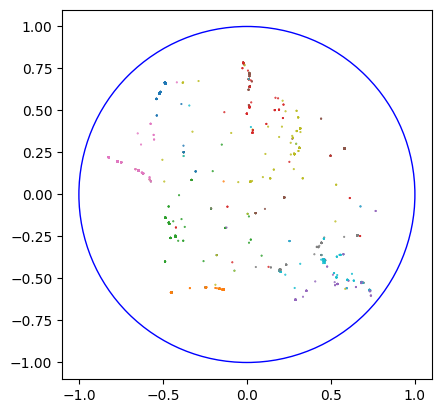

In [9]:
# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, colors=dataLabels)
fig.savefig(f"results/{dataset.name}.png")

In [10]:
# This renders a GIF animation of the embedding process. If FFMPEG is installed, the command also supports .mp4 as file ending 
animate(logging_dict, dataLabels, f"results/{dataset.name}_ani.gif", fast=True, plot_ee=True)

Animation being saved to: results/MNIST_ani.gif


Animating:   0%|          | 0/100 [00:00<?, ?it/s]/Users/haoranxia/Thesis-Delft/hyperbolic-tsne/hyperbolicTSNE/visualization.py:354: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=100.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 103it [00:04, 25.27it/s]                      
